## Combined analysis of all studies plus bloom filtered American Gut data

In [1]:
# Initializes the notebook with inline display
%matplotlib inline

from os import mkdir
import os
import copy
import qiime2 as q2
from qiime2 import Visualization
from os.path import abspath, join as pjoin, exists
from shutil import copy2, move
from time import strftime, strptime
from numpy import nan, isnan, arange
from pandas import read_csv, Series, DataFrame
from skbio import DistanceMatrix
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from pandas import ExcelFile
from qiime2 import Metadata
from qiime2.plugins import feature_table
from qiime2 import Artifact
import biom

In [2]:
def ttest(df,ttdf1,ttdf2):
    from scipy.stats import ttest_ind
    ttests=[]
    ttdf1 = ttdf1.transpose()
    ttdf2 = ttdf2.transpose()
    ttests = ttest_ind(ttdf1,ttdf2,equal_var=False,nan_policy='omit')
    ttests = ttests.pvalue.transpose()
    df['ttest_pvalue']=ttests
    
def fold(df, sub1, sub2, sub1name, sub2name):
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Overall_Mean'] = (df['%s Mean' % (sub1name)]+df['%s Mean' % (sub2name)])/2
    df['Fold Change(%s/%s)' % (sub1name,sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    print("Fold Change Column Name = 'Fold Change(%s/%s)'" %(sub1name,sub2name))
    
def piscore(df,sub1name,sub2name):
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    df['Relevance_Score'] = 1/(-np.log10(abs(df['%s/%s pi score'% (sub1name,sub2name)])*df['Overall_Mean']))

def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)

In [3]:
def PlotByCategory(df,lists,Taxa_col,metadata,category,display_number,save_descrip,human="True",top_taxa=True,Others=[],top_list=[]):
    """
    This function allows you to average the abundance of a category by the levels within that category
    and plot stacked barplots of the relative abundance of the x most abundant groups within 
    each level. Change top_taxa to False and the function will input previously calculated top category lists.
    
    Parameters
    ----------
    df : pd.DataFrame
    lists: list
    Taxa_col : String
    display_number: np.integer
    human: String
    save_descrip : String
    top_taxa: True/False

    Returns
    -------
    pdf visualization
    """
    df_all = df[lists].groupby(df['%s' % Taxa_col]).agg(['sum'])
    drop_list=[]
    
    #Remove some unwanted classifications from top list
    if set(df_all.index) & set(['k__','p__','c__','o__','f__','s__','g__','__'])!='':
        drop_list=list(set(df_all.index) & set(['k__','p__','c__','o__','f__','s__','g__','__']))
        df_all.drop(drop_list,axis=0,inplace=True)
        print('Adding uninformative features %s to "Others".'%drop_list)
    
    if top_taxa==True:
        #Find the sum per variable
        df_all['sum'] = df_all.sum(axis=1)

        #Find the most abundantly entry within the variable, group others
        top_list = list(df_all.sort_values('sum', ascending=False)[0:display_number-1].index)
        Others = list(set(df_all.index) - set(top_list)) + drop_list
        top_list.append('Others')
    
    Others = list(set(df_all.index)&set(Others))
    
    #A dictionary of dataframes will be needed to store all summed dataframes:
    #df_dict = {}

    #Initialize the figure
    figlength = 2
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(2,figlength))

 
    dfcategories = df[lists].groupby(df['%s' % Taxa_col]).agg(['sum'])
    #Restructure the columns which become multilevel with the sum function                  
    dfcategories.columns = dfcategories.columns.droplevel(1)

    if human != "True":
        dfcategories.drop('Homo sapiens (Human)', inplace=True)   
        
    counts = dfcategories
    
    #Find averages according to the levels in a category of interest
        
    #subset metadata to only list with patients of interest
    metadata.index = metadata.index.astype('str')
    meta2 = metadata.loc[lists]
    #Identify the levels within the metadata category
    levels_list = list(meta2[category].drop_duplicates().sort_values())
    #Add new column for patients regarding the level of the category of interest.
    counts.loc['%s' % category] = metadata['%s' % category]

    #Create a new column averaging by the levels within the category
    col_list = []
    
    ##NOTE - THIS STEP MAY BE REORDERING LIST SHOULD CHECK
    for j in levels_list:
        a = counts[lists].T
        patients_in = []
        patients_in = list(a[a[category] == j].index.astype('str'))
        b = counts[patients_in].drop(category)
        b = b.astype('float')
        counts['Patients_in_%s_%s_Average' % (category, j)] = b[patients_in].mean(axis=1)
        col_list.append('Patients_in_%s_%s_Average' % (category, j))



    counts.loc['Others'] = counts.loc[Others].sum()
    plot_df = counts[col_list]
    plot_df = plot_df.loc[top_list]

    #Convert to ratio for display
    for j in col_list:
        plot_df[j] = plot_df[j]/plot_df[j].sum()
    
    plot_df = plot_df[col_list]
    
    #Remove index name
    #del plot_df.index.name
    
    #Transpose
    plot_df = plot_df.transpose()

    plot1 = plot_df.plot(kind='bar', ax=axes, width = 0.8, stacked=True, colormap='tab20', title='')
    #plot1.get_xaxis().set_ticklabels([])
    plot1.get_legend().remove()
    plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig('./pdfs/Barplot_of_%s_%s.pdf' %(Taxa_col,save_descrip),bbox_inches="tight")

In [4]:
def boxplot_feature(df, meta, feat, col1, col2="None",lim="None"):
    """
    This functions takes a dataframe of metadata and a feature, and produces
    a boxplot stratifying by a metadata type.
    
    Parameters
    ----------
    df : pd.DataFrame
    meta : pd.DataFrame
    feat : String
    col1 : String
    col2 : String

    Returns
    -------
    pdf visualization
    """
    if col2=='None':
        meta2 = meta.merge(df[feat],left_index=True,right_index=True)
        fig = plt.subplots(figsize=(2,3))
        plot1 = sns.swarmplot(x=col1,y=feat,size=1.9, data=meta2)
        ax = sns.boxplot(x=col1, y=feat,color='white', linewidth='2',data=meta2,)
        rotation = 90 
        ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
        if lim!='None':
            plot1.set_ylim(0, lim)
        #Make the boxes prettier
        for i,box in enumerate(ax.artists):
            box.set_edgecolor('black')
            box.set_facecolor('white')

            #Iterate over whiskers and median lines
            for j in range(6*i,6*(i+1)):
                 ax.lines[j].set_color('black')

        plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig('./pdfs/%s_by_%s_Boxplots.pdf' %(feat,col1),bbox_inches="tight")
    else:
        meta2 = meta.merge(df[feat],left_index=True,right_index=True)
        fig = plt.subplots(figsize=(2,3))
        #plot1 = sns.swarmplot(x='Diagnosis',y='Lactobacillus',hue='Age_Group',size=7, data=meta2)
        ax = sns.boxplot(x=col2, y=feat,hue=col1,data=meta2)
        if lim!='None':
            ax.set_ylim(0, lim)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig('./pdfs/%s_Boxplots_%s_by_%s.pdf' % (feat,col1,col2),bbox_inches="tight") 

### Analysis Start

In [6]:
!qiime feature-classifier classify-sklearn \
  --i-classifier gg-13-8-99-nb-classifier.qza \
  --i-reads rep-seqs-all.qza \
  --o-classification taxonomy.qza

Saved FeatureData[Taxonomy] to: taxonomy.qza


In [7]:
!qiime fragment-insertion sepp \
  --i-representative-sequences rep-seqs-all.qza \
  --i-reference-database sepp-refs-gg-13-8.qza \
  --o-tree insertion-tree.qza \
  --o-placements insertion-placements.qza

^C

Aborted!


In [88]:
!qiime feature-table filter-samples \
  --i-table ./all_studies_filt_feature_table.qza \
  --m-metadata-file ./Master_complete_metadata_2.txt \
  --o-filtered-table ./all_studies_filt_feature_table.qza

Saved FeatureTable[Frequency] to: ./all_studies_filt_feature_table.qza


In [91]:
!qiime fragment-insertion filter-features \
  --i-table all_studies_filt_feature_table.qza \
  --i-tree insertion-tree.qza \
  --o-filtered-table all_studies_filt_feature_table.qza \
  --o-removed-table removed_table.qza

Saved FeatureTable[Frequency] to: all_studies_filt_feature_table.qza
Saved FeatureTable[Frequency] to: removed_table.qza


In [89]:
!qiime feature-table summarize \
  --i-table ./all_studies_filt_feature_table.qza \
  --o-visualization ./all_studies_filt_feature_table.qzv \
  --m-sample-metadata-file ./Master_complete_metadata_2.txt

Saved Visualization to: ./all_studies_filt_feature_table.qzv


In [171]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny ./insertion-tree.qza \
  --i-table ./sample_insertion_filtered_final_table.qza \
  --p-sampling-depth 6000 \
  --m-metadata-file ./Master_complete_metadata.txt \
  --output-dir core-metrics-results-16S-2

Saved FeatureTable[Frequency] to: core-metrics-results-16S-2/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-2/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-2/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-2/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results-16S-2/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results-16S-2/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-2/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-2/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results-16S-2/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results-16S-2/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-16S-2/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-metrics-results-16S-2/jaccard_pcoa_re

In [196]:
!qiime diversity alpha-rarefaction \
  --i-table all_studies_filt_feature_table.qza \
  --i-phylogeny insertion-tree.qza \
  --p-max-depth 276513 \
  --m-metadata-file Master_complete_metadata.txt \
  --o-visualization alpha-rarefaction.qzv

Saved Visualization to: alpha-rarefaction.qzv


In [27]:
!qiime feature-table summarize \
  --i-table ./core-metrics-results-16S/rarefied_table.qza \
  --o-visualization ./rarefied_table.qzv \
  --m-sample-metadata-file ./Master_complete_metadata.txt

Saved Visualization to: ./rarefied_table.qzv


In [75]:
#Min reads/sample is ~0 Rarefy to 6000
tableViz = Visualization.load('./all_studies_filt_feature_table.qzv')
tableViz

<visualization: Visualization uuid: 989ad514-b2e4-47aa-8123-46d7b6104739>

In [94]:
Viz = Visualization.load('./core-metrics-results-16S-2/unweighted_unifrac_emperor.qzv')
Viz

<visualization: Visualization uuid: 5d9732c2-4ee9-414e-bc45-e51ccc5c9f87>

In [91]:
Viz = Visualization.load('./core-metrics-results-16S/weighted_unifrac_emperor.qzv')
Viz

<visualization: Visualization uuid: 2df21074-cb13-4123-960a-7e3198d4e6c3>

In [62]:
!qiime diversity beta-group-significance \
--i-distance-matrix ./core-metrics-results-16S/weighted_unifrac_distance_matrix.qza \
--m-metadata-file ./Master_complete_metadata.txt \
--m-metadata-column 'Study' \
--output-dir ./core-metrics-results-16S/Status_permanova_weighted_Study

Saved Visualization to: ./core-metrics-results-16S/Status_permanova_weighted_Study/visualization.qzv


In [60]:
!qiime diversity beta-group-significance \
--i-distance-matrix ./core-metrics-results-16S/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file ./Master_complete_metadata.txt \
--m-metadata-column 'Study' \
--output-dir ./core-metrics-results-16S/Status_permanova_unweighted_Study

Saved Visualization to: ./core-metrics-results-16S/Status_permanova_unweighted_Study/visualization.qzv


In [67]:
Viz = Visualization.load('./core-metrics-results-16S/Status_permanova_weighted_Study/visualization.qzv')
Viz

<visualization: Visualization uuid: 14f18a5f-e4bf-4684-917e-271e64c68d43>

In [92]:
Viz = Visualization.load('./core-metrics-results-16S/Status_permanova_unweighted_correct/visualization.qzv')
Viz

<visualization: Visualization uuid: 3497105b-61f0-4093-8850-517bb049569d>

In [87]:
!qiime diversity beta-group-significance \
--i-distance-matrix ./core-metrics-results-16S/weighted_unifrac_distance_matrix.qza \
--m-metadata-file ./Master_complete_metadata.txt \
--m-metadata-column 'Status' \
--output-dir ./core-metrics-results-16S/Status_permanova_weighted_status

Saved Visualization to: ./core-metrics-results-16S/Status_permanova_weighted_status/visualization.qzv


In [88]:
!qiime diversity beta-group-significance \
--i-distance-matrix ./core-metrics-results-16S/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file ./Master_complete_metadata.txt \
--m-metadata-column 'Status' \
--output-dir ./core-metrics-results-16S/Status_permanova_unweighted_status

Saved Visualization to: ./core-metrics-results-16S/Status_permanova_unweighted_status/visualization.qzv


In [89]:
Viz = Visualization.load('./core-metrics-results-16S/Status_permanova_unweighted_status/visualization.qzv')
Viz

<visualization: Visualization uuid: 65ea04d5-405e-4260-a645-b6bff2eaa208>

In [90]:
Viz = Visualization.load('./core-metrics-results-16S/Status_permanova_weighted_status/visualization.qzv')
Viz

<visualization: Visualization uuid: ef8e1e59-fe52-43dc-b445-d2614681e144>

In [46]:
!qiime diversity adonis \
--i-distance-matrix ./core-metrics-results-16S/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file ./Master_complete_metadata.txt \
--p-formula "Status*seq_depth_range*Country*Variable_Region*Study*Control_relation" \
--o-visualization ./core-metrics-results-16S/Adonis_unweighted_status_VR_study_CF_SD_Country_2.qzv

Saved Visualization to: ./core-metrics-results-16S/Adonis_unweighted_status_VR_study_CF_SD_Country_2.qzv


In [47]:
Viz = Visualization.load('./core-metrics-results-16S/Adonis_unweighted_status_VR_study_CF_SD_Country_2.qzv')
Viz

<visualization: Visualization uuid: e66621b5-7cfd-4616-abcf-1be7d4c9e8c2>

In [33]:
!qiime diversity adonis \
--i-distance-matrix ./core-metrics-results-16S/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file ./Master_complete_metadata.txt \
--p-formula "Status*Variable_Region*Study" \
--o-visualization ./core-metrics-results-16S/Status_permanova_unweighted_study_VR_sex_study.qzv

Saved Visualization to: ./core-metrics-results-16S/Status_permanova_unweighted_study_VR_sex_study.qzv


In [34]:
Viz = Visualization.load('././core-metrics-results-16S/Status_permanova_unweighted_study_VR_sex_study.qzv')
Viz

<visualization: Visualization uuid: 716aee3f-afdc-45df-92c1-bc09d479612d>

In [40]:
cb.generate_collapsed_table(Path='./',Biom_Table='./rarefied_to_6000/feature-table.biom',
                         metadata='./Master_complete_metadata.txt',Seqs='./rarefied_to_6000/rep_seqs.fna',
                         md=False,level='Species')

mkdir: ./: File exists
There was a problem importing ./rarefied_to_6000/rep_seqs.fna:

  rarefied_to_6000/rep_seqs.fna is not a(n) DNAFASTAFormat file:

  Invalid character '0' at position 0 on line 2 (does not match IUPAC characters for a DNA sequence).

Usage: qiime feature-classifier classify-sklearn [OPTIONS]

  Classify reads by taxon using a fitted classifier.

Inputs:
  --i-reads ARTIFACT FeatureData[Sequence]
                         The feature data to be classified.         [required]
  --i-classifier ARTIFACT
    TaxonomicClassifier  The taxonomic classifier for classifying the reads.
                                                                    [required]
Parameters:
  --p-reads-per-batch INTEGER
    Range(0, None)       Number of reads to process in each batch. If "auto",
                         this parameter is autoscaled to min( number of query
                         sequences / n-jobs, 20000).              [default: 0]
  --p-n-jobs INTEGER     The maximum numb

In [43]:
cb.generate_collapsed_table(Path='./',Biom_Table='./rarefied_to_6000/feature-table.biom',
                         metadata='./Master_complete_metadata.txt',Seqs='./rarefied_to_6000/rep_seqs.fna',
                         md=False,level='Genus',skip_prep=True)

Skipping preparation of taxonomy
'./Taxa_table_Genus_collapsed.txt' successfully saved.


In [44]:
cb.generate_collapsed_table(Path='./',Biom_Table='./rarefied_to_6000/feature-table.biom',
                         metadata='./Master_complete_metadata.txt',Seqs='./rarefied_to_6000/rep_seqs.fna',
                         md=False,level='Phyla',skip_prep=True)

Skipping preparation of taxonomy
'./Taxa_table_Phyla_collapsed.txt' successfully saved.


In [50]:
cb.generate_collapsed_table(Path='./',Biom_Table='./rarefied_to_6000/feature-table.biom',
                         metadata='./Master_complete_metadata.txt',Seqs='./rarefied_to_6000/rep_seqs.fna',
                         md=False,level='Class',skip_prep=True)

Skipping preparation of taxonomy
'./Taxa_table_Class_collapsed.txt' successfully saved.


In [48]:
cb.generate_collapsed_table(Path='./',Biom_Table='./rarefied_to_6000/feature-table.biom',
                         metadata='./Master_complete_metadata.txt',Seqs='./rarefied_to_6000/rep_seqs.fna',
                         md=False,level='Order',skip_prep=True)

Skipping preparation of taxonomy
'./Taxa_table_Order_collapsed.txt' successfully saved.


In [49]:
cb.generate_collapsed_table(Path='./',Biom_Table='./rarefied_to_6000/feature-table.biom',
                         metadata='./Master_complete_metadata.txt',Seqs='./rarefied_to_6000/rep_seqs.fna',
                         md=False,level=None,skip_prep=True)

Skipping preparation of taxonomy
'./Taxa_table_None_collapsed.txt' successfully saved.


In [50]:
meta = pd.read_csv('./Master_complete_metadata.txt',sep='\t',index_col=0) 

In [51]:
meta["Variable_Region"].replace({"V3-V4": "V3V4"}, inplace=True)

In [53]:
meta = pd.read_csv('./Master_complete_metadata.txt',sep='\t',index_col=0)
ASD_ids = list(meta[meta['Status']=='ASD'].index)
Control_ids = list(meta[meta['Status']=='Control'].index)

levels = ['Phyla','Class','Order','Genus','Species','None']


for i in levels:
    df = pd.read_csv('./Taxa_table_%s_collapsed.txt'%i,sep='\t',index_col=0)   
    
    df = df.T
    
    for j in df.columns:
        df[j]=df[j]/df[j].sum()
    
    df = df.T

    if i == 'Phyla':
        df['Firmicutes/Bacteroidetes'] = df[' p__Firmicutes']/df[' p__Bacteroidetes']       
    if i == 'Genus':
        df['Prevotella/Bacteroides'] = df[' g__Prevotella']/df[' g__Bacteroides']
    if i == 'Phyla':
        df['Proteobacteria/Bacteroidetes'] = df[' p__Proteobacteria']/df[' p__Bacteroidetes']
        
    df = df.T

    ASD_ids = list(set(ASD_ids)&set(df.columns))
    Control_ids = list(set(Control_ids)&set(df.columns))
    ASD = df[ASD_ids]
    Control = df[Control_ids]
        
    TwoCategoryMaster(dfmain=df,dfsub1=ASD,
                      dfsub2=Control,sub1name='ASD',sub2name='Control')
    
    
    ##Record Firmicutes/Bacteroidetes ratios
    if i == 'Phyla':
        FB_ratio = df.loc['Firmicutes/Bacteroidetes']
        indices=['Fold Change(ASD/Control)','ttest_pvalue','ASD Mean','Control Mean']
        metrics = FB_ratio.loc[indices]
        metrics.to_csv('./All_studies_FB_ratio_stats.csv')
        print('./All_studies_FirmicutesToBacteroidetes_ratio_stats.csv saved') 
    
    ##Record Prevotella/Bacteroides ratios
    if i == 'Genus':
        PB_ratio = df.loc['Prevotella/Bacteroides']
        indices=['Fold Change(ASD/Control)','ttest_pvalue']
        metrics = PB_ratio.loc[indices]
        metrics.to_csv('./All_studies_PB_ratio_stats.csv')
        print('./All_studies_PrevotellaToBacteroides_ratio_stats.csv saved') 
        
    ##Record Proteobacteria/Bacteroidetes ratios
    if i == 'Phyla':
        Proteobacteria_Bacteroidetes_ratio = df.loc['Proteobacteria/Bacteroidetes']
        indices=['Fold Change(ASD/Control)','ttest_pvalue']
        metrics = Proteobacteria_Bacteroidetes_ratio.loc[indices]
        metrics.to_csv('./All_studies_Proteobacteria_Bacteroidetes_ratio_stats.csv')
        print('./All_studies_ProteobacteriaToBacteroidetes_ratio_stats.csv saved') 

    
    df.to_csv('./%s_table_ASDvControl_pvalues.csv'%i)
    print('./%s_table_ASDvControl_pvalues.csv saved'%i)

Fold Change Column Name = 'Fold Change(ASD/Control)'
./All_studies_FirmicutesToBacteroidetes_ratio_stats.csv saved
./All_studies_ProteobacteriaToBacteroidetes_ratio_stats.csv saved
./Phyla_table_ASDvControl_pvalues.csv saved
Fold Change Column Name = 'Fold Change(ASD/Control)'
./Class_table_ASDvControl_pvalues.csv saved
Fold Change Column Name = 'Fold Change(ASD/Control)'
./Order_table_ASDvControl_pvalues.csv saved
Fold Change Column Name = 'Fold Change(ASD/Control)'
./All_studies_PrevotellaToBacteroides_ratio_stats.csv saved
./Genus_table_ASDvControl_pvalues.csv saved
Fold Change Column Name = 'Fold Change(ASD/Control)'
./Species_table_ASDvControl_pvalues.csv saved
Fold Change Column Name = 'Fold Change(ASD/Control)'
./None_table_ASDvControl_pvalues.csv saved


In [53]:
df = pd.read_csv('./Taxa_table_None_collapsed.txt',sep='\t',index_col=0)

ASD_ids = list(meta[meta['Variable_Region']=='V3V4'].index)
Control_ids = list(meta[meta['Variable_Region']=='V4'].index)
ASD_ids = list(set(ASD_ids)&set(df.columns))
Control_ids = list(set(Control_ids)&set(df.columns))

In [54]:
#Prep df2 with columns for each taxonomic level
df = df.T
samples=list(df.columns)
df['Taxa']=df.index
s = df['Taxa'].str.split(';', expand = True)
s=s.rename(columns={0:'Kingdom',1:'Phyla',2:'Class',3:'Order',4:'Family',5:'Genus',6:'Species'})
df2=df.merge(s,left_index=True,right_index=True)

Adding uninformative features [] to "Others".


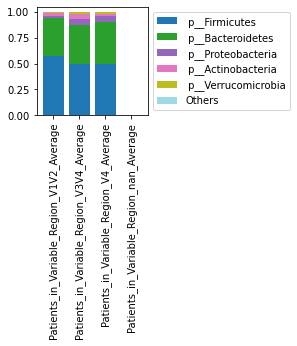

In [58]:
PlotByCategory(df=df2,lists=samples,Taxa_col='Phyla',
               category='Variable_Region',metadata=meta,
               display_number=6,save_descrip='Variable_Region',human="True")

Adding uninformative features [] to "Others".


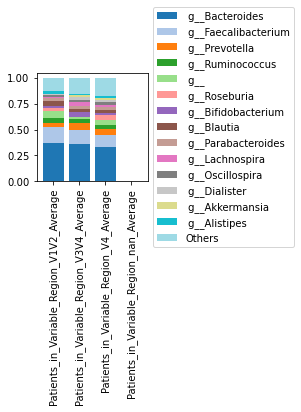

In [60]:
PlotByCategory(df=df2,lists=samples,Taxa_col='Genus',
               category='Variable_Region',metadata=meta,
               display_number=15,save_descrip='Variable_Region',human="True")

## Picrust Analysis

##### Picrust2 pathway analysis

Switched environment to run Picrust2: https://github.com/picrust/picrust2/wiki/Installation
<br><br>
<i>Run in terminal on first install:</i>
conda create -n picrust2 -c bioconda -c conda-forge picrust2=2.4.1
<br>conda activate picrust2

<br><br>
Run this for generating picrust2 tables:<br>
picrust2_pipeline.py -s ./reference-hit.seqs.fa -i ./reference-hit.biom -o picrust2_out_pipeline -p 1

In [38]:
Six_thousand_filtered_metadata = mf[mf['#SampleID'].isin(samples_to_keep)]
Six_thousand_filtered_metadata

,#SampleID,Age,Control_Relation,Control_Type,Control_relation,Country,Sample_size,Sex,Status,Study,Variable_Region,sequencing_depth_min,Age_Range,seq_depth_range
0,56608.10317.000059852,7.0,NaN,Age_Sex_Match,No Relationship,NaN,532.0,male,ASD,American Gut,V4,6000.0,5-7 years,< 6000
1,56608.10317.000073749,9.0,NaN,Age_Sex_Match,No Relationship,NaN,532.0,male,ASD,American Gut,V4,6000.0,Above 7 years,< 6000
2,56608.10317.000072136,10.0,NaN,Age_Sex_Match,No Relationship,NaN,532.0,male,ASD,American Gut,V4,6000.0,Above 7 years,< 6000
3,56608.10317.000073612,18.0,NaN,Age_Sex_Match,No Relationship,NaN,532.0,male,ASD,American Gut,V4,6000.0,Above 7 years,< 6000
4,56754.10317.000021574,5.0,NaN,Age_Sex_Match,No Relationship,NaN,532.0,male,ASD,American Gut,V4,6000.0,5-7 years,< 6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,P53.stool,8.0,NaN,Age_sex_no_relation,No Relationship,Ecuador,50.0,male,Control,Zurita2019,V4,5802.0,Above 7 years,< 6000
1736,P54.stool,5.0,NaN,Age_sex_no_relation,No Relationship,Ecuador,50.0,female,Control,Zurita2019,V4,5802.0,5-7 years,< 6000
1737,P55.stool,11.0,NaN,Age_sex_no_relation,No Relationship,Ecuador,50.0,male,Control,Zurita2019,V4,5802.0,Above 7 years,< 6000
1738,P56.stool,12.0,NaN,Age_sex_no_relation,No Relationship,Ecuador,50.0,male,Control,Zurita2019,V4,5802.0,Above 7 years,< 6000


In [44]:
Six_thousand_filtered_metadata.set_index = Six_thousand_filtered_metadata["#SampleID"]

In [47]:
Six_thousand_filtered_metadata.to_csv("Six_thousand_filtered_metadata.txt", sep='\t')

In [48]:
!qiime feature-table filter-samples \
  --i-table ./All_studies_plut_amgut_feature_table.qza \
  --m-metadata-file ./Six_thousand_filtered_metadata.txt \
  --o-filtered-table ./below_6000_filtered/filt-deblur-table.qza

Saved FeatureTable[Frequency] to: ./below_6000_filtered/filt-deblur-table.qza


In [ ]:
!gunzip ./picrust2_out_pipeline/pathways_out/path_abun_unstrat.tsv.gz

In [108]:
!gunzip ./picrust2_out_pipeline/pathways_out/path_abun_unstrat_descrip.tsv.gz

In [303]:
df = pd.read_csv('./Pathway_piscores_with_descrip.csv',sep=",",index_col=0)
df

,SRR12180512,SRR12180606,SRR12180382,SRR12180406,SRR12180491,SRR12180500,SRR12180540,SRR12180556,SRR12180595,SRR12180600,...,103430.10317.000115679,ttest_pvalue,ASD Mean,Control Mean,Overall_Mean,Fold Change(ASD/Control),Log2(Fold Change),-Log(P-value),ASD/Control pi score,Relevance_Score
description,,,,,,,,,,,,,,,,,,,,,
N10-formyl-tetrahydrofolate biosynthesis,0.007046,0.007059,0.006973,0.006909,6.823891e-03,0.006149,0.007712,0.006129,0.006664,0.006909,...,0.007053,0.507301,0.006839,0.006859,0.006849,0.997119,-0.004162,0.294734,-0.001227,0.197019
4-hydroxyphenylacetate degradation,0.000017,0.000009,0.000000,0.000003,9.423677e-05,0.000428,0.000185,0.000023,0.000163,0.000031,...,0.000000,0.980877,0.000053,0.000053,0.000053,1.005981,0.008603,0.008385,0.000072,0.118774
aerobactin biosynthesis,0.000014,0.000007,0.000000,0.000003,8.039061e-05,0.000415,0.000182,0.000011,0.000153,0.000023,...,0.000000,0.281047,0.000028,0.000040,0.000034,0.704290,-0.505759,0.551220,-0.278785,0.199256
superpathway of chorismate metabolism,0.000089,0.000037,0.000000,0.000089,4.878591e-04,0.001337,0.000806,0.000587,0.000593,0.000155,...,0.000040,0.301561,0.000327,0.000297,0.000312,1.100838,0.138603,0.520625,0.072160,0.215165
homolactic fermentation,0.007068,0.006572,0.006565,0.005847,6.013951e-03,0.005766,0.003764,0.005744,0.005631,0.007103,...,0.007943,0.290231,0.006266,0.006210,0.006238,1.009080,0.013040,0.537256,0.007006,0.229385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L-tyrosine degradation I,0.000000,0.000000,0.000000,0.000000,8.058478e-07,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.568467,0.000042,0.000053,0.000047,0.798068,-0.325417,0.245294,-0.079823,0.184451
superpathway of ubiquinol-8 biosynthesis (prokaryotic),0.000034,0.000019,0.000003,0.000181,2.579758e-04,0.000680,0.000395,0.001035,0.000281,0.000076,...,0.000009,0.412149,0.000345,0.000319,0.000332,1.083158,0.115244,0.384946,0.044363,0.206950
UDP-N-acetyl-D-glucosamine biosynthesis I,0.005367,0.004399,0.005668,0.005420,3.879390e-03,0.003990,0.002330,0.004591,0.003204,0.004314,...,0.006072,0.893700,0.004484,0.004494,0.004489,0.997802,-0.003174,0.048808,-0.000155,0.162397


In [148]:
df = pd.read_csv('./picrust2_out_pipeline/pathways_out/path_abun_unstrat_descrip.tsv',sep="\t",index_col=0)
df.reset_index(inplace=True)
del df['pathway']
df = df.set_index(['description'])

for j in df.columns:
    df[j]=df[j]/df[j].sum()

ASD_ids = list(set(ASD_ids)&set(df.columns))
Control_ids = list(set(Control_ids)&set(df.columns))
ASD = df[ASD_ids]
Control = df[Control_ids]

TwoCategoryMaster(dfmain=df,dfsub1=ASD,
                  dfsub2=Control,sub1name='ASD',sub2name='Control')
#Save csvs
df.to_csv('./Pathway_piscores_with_descrip.csv')

Fold Change Column Name = 'Fold Change(ASD/Control)'


/Users/arieschavira/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Picrust data comparisons for V3V4 vs V4 Regions

In [12]:
v4_ids = list(meta[meta['Variable_Region']=='V4'].index)
v3v4_ids = list(meta[meta['Variable_Region']=='V3V4'].index)
USA_ids = list(meta[meta['Country']=='USA'].index)
China_ids = list(meta[meta['Country']=='China'].index)

In [11]:
USA = meta[meta['Country']=='USA']
China = meta[meta['Country']=='China']

In [282]:
v4 = meta[meta['Variable_Region']=='V4']
v3v4 = meta[meta['Variable_Region']=='V3V4']

In [13]:
df = pd.read_csv('./picrust2_out_pipeline/pathways_out/path_abun_unstrat_descrip.tsv',sep="\t",index_col=0)
df.reset_index(inplace=True)
del df['pathway']
df = df.set_index(['description'])

df = df.T
df = df[df.index.isin(v4_ids)]
df = df.T

try:  
    for j in df.columns:
        df[j]=df[j]/df[j].sum()
except ZeroDivisionError:  
    print ("Zero Division Exception Raised." )
else:  
    print ("Success, no error!")
    
ASD_ids = list(v4[v4['Status']=='ASD'].index)
Control_ids = list(v4[v4['Status']=='Control'].index)
ASD_ids = list(set(ASD_ids)&set(df.columns))
Control_ids = list(set(Control_ids)&set(df.columns))
ASD = df[ASD_ids]
Control = df[Control_ids]

TwoCategoryMaster(dfmain=df,dfsub1=ASD,
                  dfsub2=Control,sub1name='ASD',sub2name='Control')
#Save csvs
df.to_csv('./Pathway_piscores_with_descrip_v4.csv')

Success, no error!
Fold Change Column Name = 'Fold Change(ASD/Control)'


/Users/arieschavira/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [293]:
df = pd.read_csv('./picrust2_out_pipeline/pathways_out/path_abun_unstrat_descrip.tsv',sep="\t",index_col=0)
df.reset_index(inplace=True)
del df['pathway']
df = df.set_index(['description'])

df = df.T
df = df[df.index.isin(v3v4_ids)]
df = df.T

for j in df.columns:
    df[j]=df[j]/df[j].sum()
    
ASD_ids = list(v3v4[v3v4['Status']=='ASD'].index)
Control_ids = list(v3v4[v3v4['Status']=='Control'].index)
ASD_ids = list(set(ASD_ids)&set(df.columns))
Control_ids = list(set(Control_ids)&set(df.columns))
ASD = df[ASD_ids]
Control = df[Control_ids]


TwoCategoryMaster(dfmain=df,dfsub1=ASD,
                  dfsub2=Control,sub1name='ASD',sub2name='Control')
#Save csvs
df.to_csv('./Pathway_piscores_with_descrip_v3v4.csv')

Fold Change Column Name = 'Fold Change(ASD/Control)'


### Picrust data comparisons for China vs USA

In [16]:
# China Analysis
df = pd.read_csv('./picrust2_out_pipeline/pathways_out/path_abun_unstrat_descrip.tsv',sep="\t",index_col=0)
df.reset_index(inplace=True)
del df['pathway']
df = df.set_index(['description'])

df = df.T 
df = df[df.index.isin(China_ids)]
df = df.T

try:  
    for j in df.columns:
        df[j]=df[j]/df[j].sum()
except ZeroDivisionError:  
    print ("Zero Division Exception Raised." )
else:  
    print ("Success, no error!")
    
ASD_ids = list(China[China['Status']=='ASD'].index)
Control_ids = list(China[China['Status']=='Control'].index)
ASD_ids = list(set(ASD_ids)&set(df.columns))
Control_ids = list(set(Control_ids)&set(df.columns))
ASD = df[ASD_ids]
Control = df[Control_ids]

TwoCategoryMaster(dfmain=df,dfsub1=ASD,
                  dfsub2=Control,sub1name='ASD',sub2name='Control')
#Save csvs
df.to_csv('./Pathway_piscores_with_descrip_China.csv')

Success, no error!
Fold Change Column Name = 'Fold Change(ASD/Control)'


In [17]:
# USA Analysis
df = pd.read_csv('./picrust2_out_pipeline/pathways_out/path_abun_unstrat_descrip.tsv',sep="\t",index_col=0)
df.reset_index(inplace=True)
del df['pathway']
df = df.set_index(['description'])

df = df.T 
df = df[df.index.isin(USA_ids)]
df = df.T

try:  
    for j in df.columns:
        df[j]=df[j]/df[j].sum()
except ZeroDivisionError:  
    print ("Zero Division Exception Raised." )
else:  
    print ("Success, no error!")
    
ASD_ids = list(USA[USA['Status']=='ASD'].index)
Control_ids = list(USA[USA['Status']=='Control'].index)
ASD_ids = list(set(ASD_ids)&set(df.columns))
Control_ids = list(set(Control_ids)&set(df.columns))
ASD = df[ASD_ids]
Control = df[Control_ids]

TwoCategoryMaster(dfmain=df,dfsub1=ASD,
                  dfsub2=Control,sub1name='ASD',sub2name='Control')
#Save csvs
df.to_csv('./Pathway_piscores_with_descrip_USA.csv')

Success, no error!
Fold Change Column Name = 'Fold Change(ASD/Control)'
